In [1]:
import numpy as np
import os
import glob
import pandas as pd
from sklearn.manifold import Isomap,\
                            LocallyLinearEmbedding,\
                            SpectralEmbedding,\
                            TSNE,\
                            locally_linear_embedding
from umap import UMAP
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import ParameterGrid

from joblib import Parallel, delayed
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from utils import transform, calculate_Q_metrics, KNN_MAE
from IPython.display import clear_output
N_CPU = cpu_count()

import warnings
warnings.simplefilter("ignore")
plt.rcParams.update({'font.size': 20})

# Load data

In [2]:
DATA_SPECIFICATION = 'data_processed_small'

intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict{DATA_SPECIFICATION}.npy', allow_pickle=True).item()

data_orig = {}
for dataset_name in tqdm(['PLSF', 'StCh', 'Buff', 'Champ', 'Conest', 'rotor', 'otherLake']):
    for tax in ['g']: 
        dataframe = pd.read_csv(f'./data_processed_small/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values

data_pca = {}
for dataset_name in tqdm(['PLSF', 'StCh', 'Buff', 'Champ', 'Conest', 'rotor', 'otherLake']):
    for tax in ['g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca/{label}', delimiter=';')
        
embeddings_root = f'results/embeddings{DATA_SPECIFICATION}'
embeddings_params_root = f'results/embeddings_params{DATA_SPECIFICATION}/'

os.makedirs(embeddings_root, exist_ok=True)
os.makedirs(embeddings_params_root, exist_ok=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 446.35it/s]


# Hyperparameters Grid Search

In [ ]:
# # uncomment to use synthetic data

# intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict_synthetic.npy', allow_pickle=True).item()

# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

    
# embeddings_root = 'results/embeddings_synthetic'
# embeddings_params_root = 'results/embeddings_params_synthetic/'

# os.makedirs(embeddings_root, exist_ok=True)
# os.makedirs(embeddings_params_root, exist_ok=True)

In [3]:
# setting `include_Q_scores = True` significantly impedes the hyperparameter search,
# but allows to estimate Q-metrics for every combination
include_Q_scores = False

knn_mae_scorer = lambda *args: KNN_MAE(*args, averaging='median', weights='distance', n_neighbors=5)

if include_Q_scores:
    scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])
else:
    scorer = knn_mae_scorer

In [4]:
baseline_errors = {}
for label, X in tqdm((data_pca.items())):
    baseline_errors[label] = knn_mae_scorer(X,X)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 601.99it/s]


In [5]:
mf_models = {
    
            'isomap':{'class':Isomap, 'params_grid':{'n_neighbors':[5,10,15,25],
                                                      'p':[1,2],
                                                      'metric':['minkowski'],
                                                      'n_jobs':[1]
                                                     }
                      },
    
    
            'spectral':{'class':SpectralEmbedding, 'params_grid':{'affinity':['nearest_neighbors', 'rbf'],
                                                                   'n_neighbors':[5,10,15,25],
                                                                   'gamma':[1e-4, 1e-3, 1e-2, None, 1e-1],
                                                                   'random_state':[42],
                                                                   'n_jobs':[1]
                                                                  }
                        },
    

            'lle':{'class':LocallyLinearEmbedding, 'params_grid':{'method':['ltsa', 'standard'],
                                                       'reg':[0.0001, 0.001, 0.01],
                                                       'n_neighbors':[10,15,25,50],
                                                       'random_state':[42],
                                                       'n_jobs':[1],
                                                       'eigen_solver':['dense']
                                                     }
                  },
    
            'umap':{'class':UMAP, 'params_grid':{'n_neighbors':[5,10,15,25,50],
                                                 'min_dist':[0.05, 0.1, 0.25, 0.5],
                                                 'learning_rate':[0.1, 1],
                                                 'random_state':[42],
                                                 'metric':['manhattan'],
                                                 'n_epochs':[2000], # changerd from 2000
                                                 'n_jobs':[1]
                                                }
                   },
    
            'tsne':{'class':TSNE, 'params_grid':{'perplexity':[5,10,15,25,50],
                                                 'random_state':[42],
                                                 'early_exaggeration':[5,10,25],
                                                 'init':['pca'],
                                                 'metric':['manhattan'],
                                                 'method':['exact'],
                                                 'n_jobs':[1],
                                                 'n_iter':[2000],
                                                 'n_iter_without_progress':[100]
                                                 }
                   } 
            }

# iterate over the models
for mf_type, model in mf_models.items():    
    # iterate over the datasets
    for i,(label, X) in tqdm(enumerate(data_pca.items())):
        
        results = {}
        results_path = os.path.join(embeddings_params_root,\
                                    f'pca_{mf_type}_{label}')
        
        if os.path.isfile(results_path + '.npy'):
            print(f'{results_path} exists, skipping...')
            continue

        dim = intrinsic_dims[label]
        print('Calculating...', label, 'Method:', mf_type, 'Intrinsic dim:', dim)

        model_class = model['class']
        model_param_grid = model['params_grid']
        
        try:
            scores = Parallel(n_jobs=-1)(delayed(transform)(model_class,
                                                            X, 
                                                            dim,
                                                            model_params,
                                                            scorer) \
                              for model_params in list(ParameterGrid(model_param_grid)))  
            
            results['scores'] = scores
            results['params'] = model_param_grid
            np.save(results_path, results)
            
        except Exception as e:
            print(f'Failed to estimate perameters for {mf_type}, {label}:', e)
            continue
            
clear_output()

In [ ]:
# Visualize KNN MAE, select best hyperparameters

In [6]:
all_metrics = defaultdict(dict)

for metrics_results_name in \
                   filter(lambda x: 'pca' in x, os.listdir(embeddings_params_root)):
    
    mf_type, dataset_name, tax_name = metrics_results_name.split('.')[0].split('_')[-3:]
    label = '_'.join([dataset_name, tax_name])
    all_metrics[mf_type][label] = np.load(os.path.join(embeddings_params_root, 
                                          metrics_results_name), \
                                          allow_pickle=True).item()

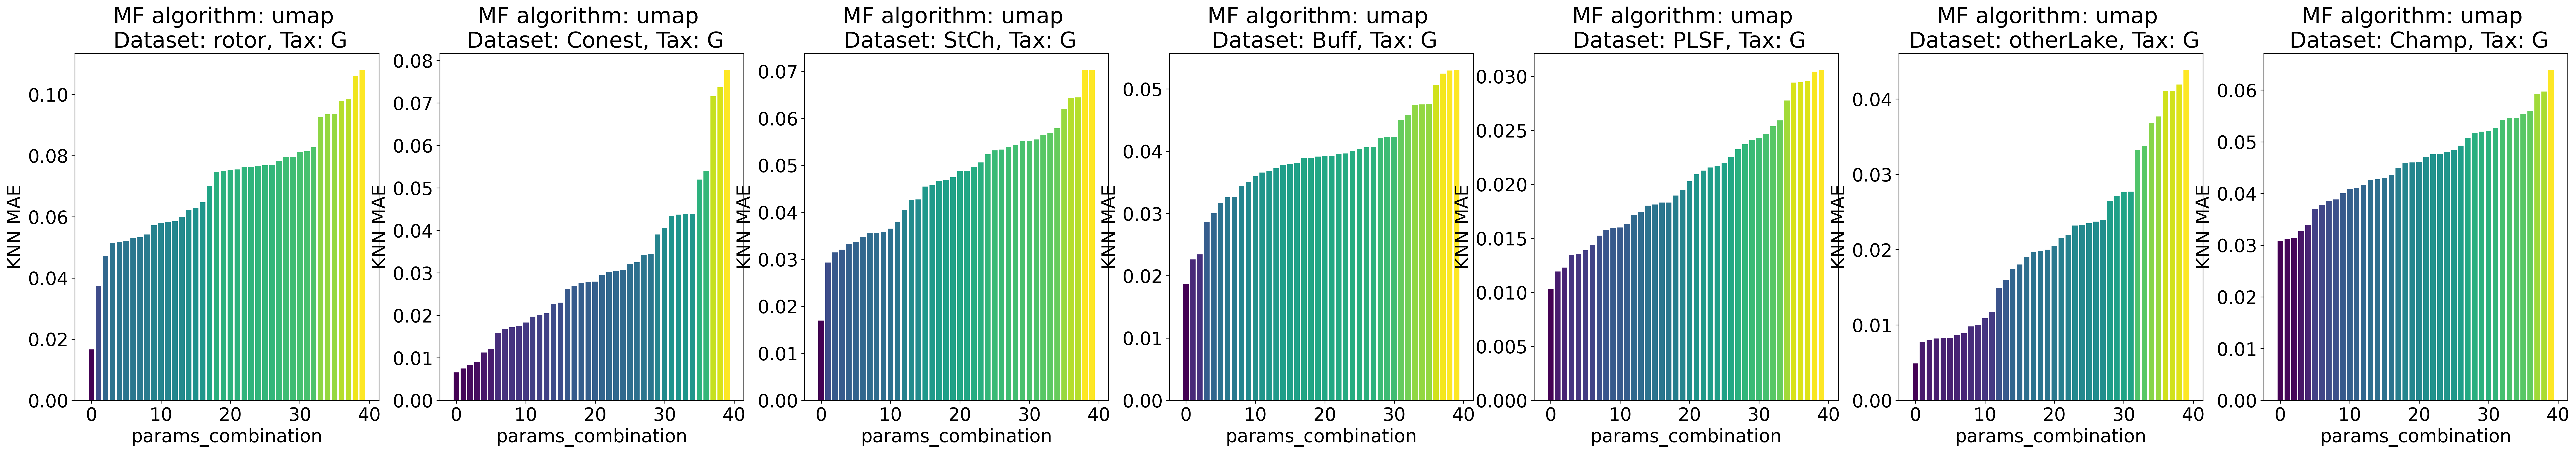

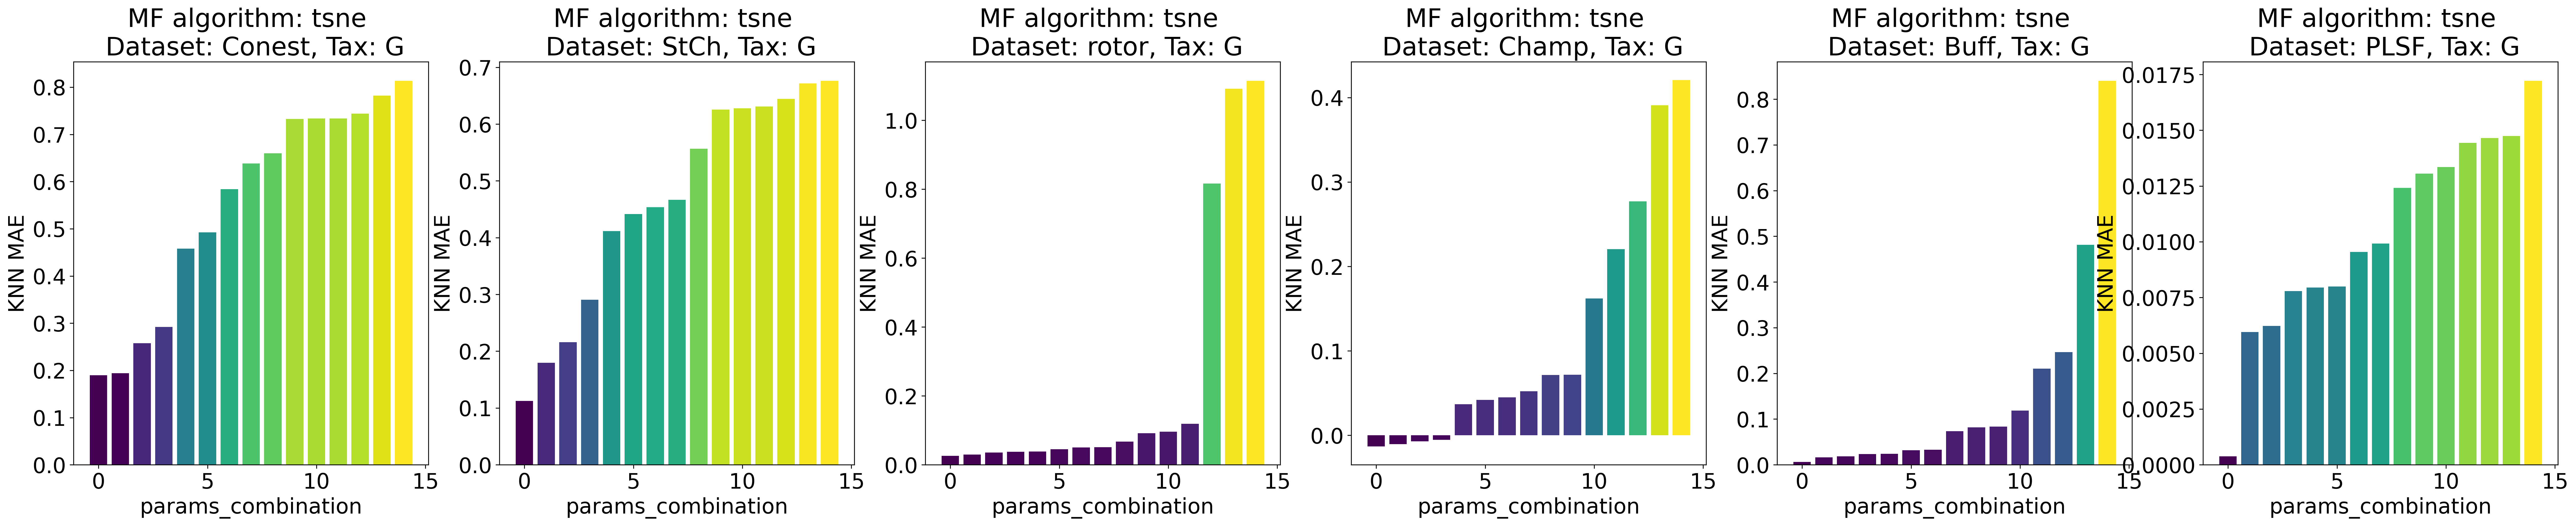

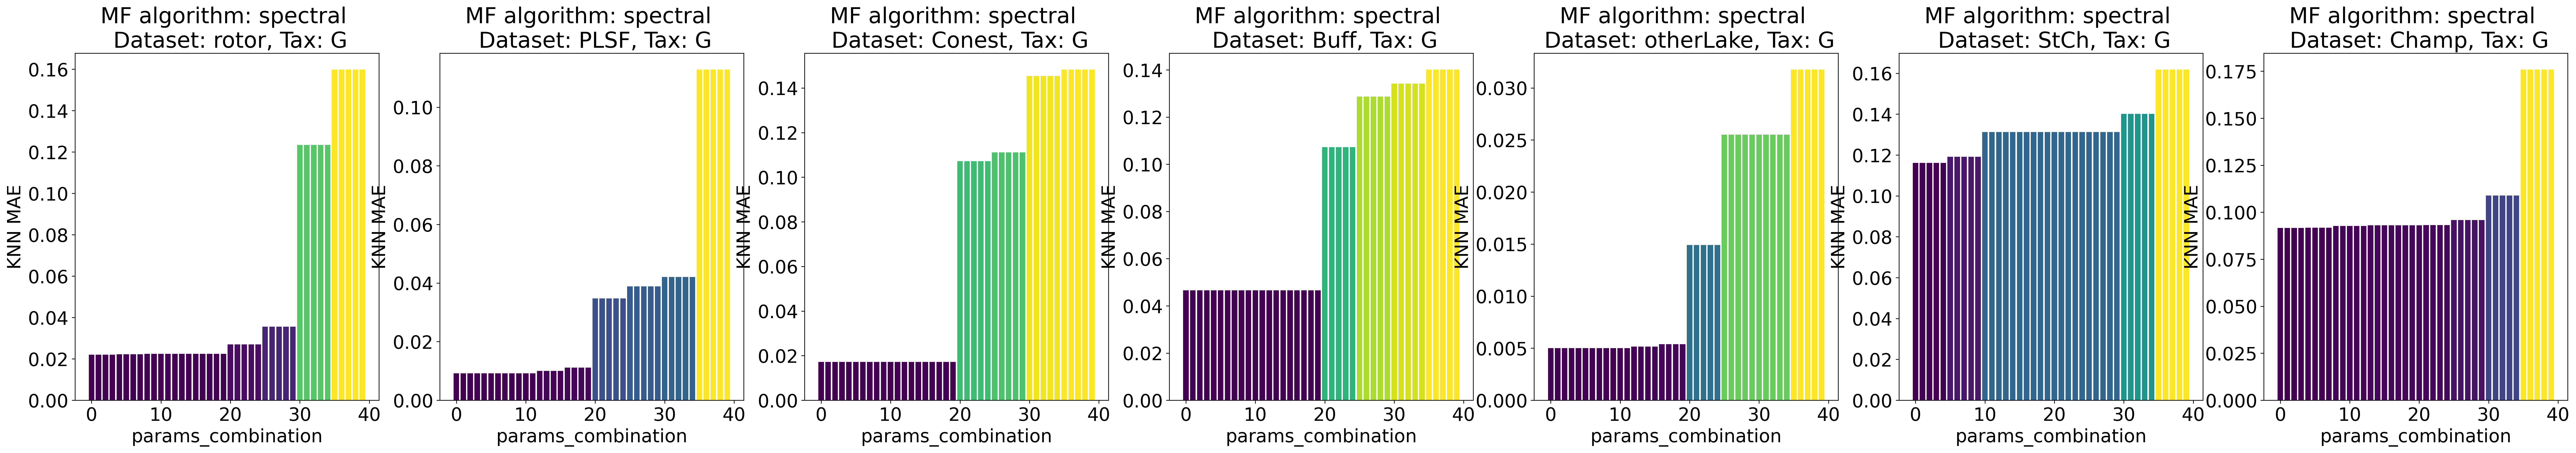

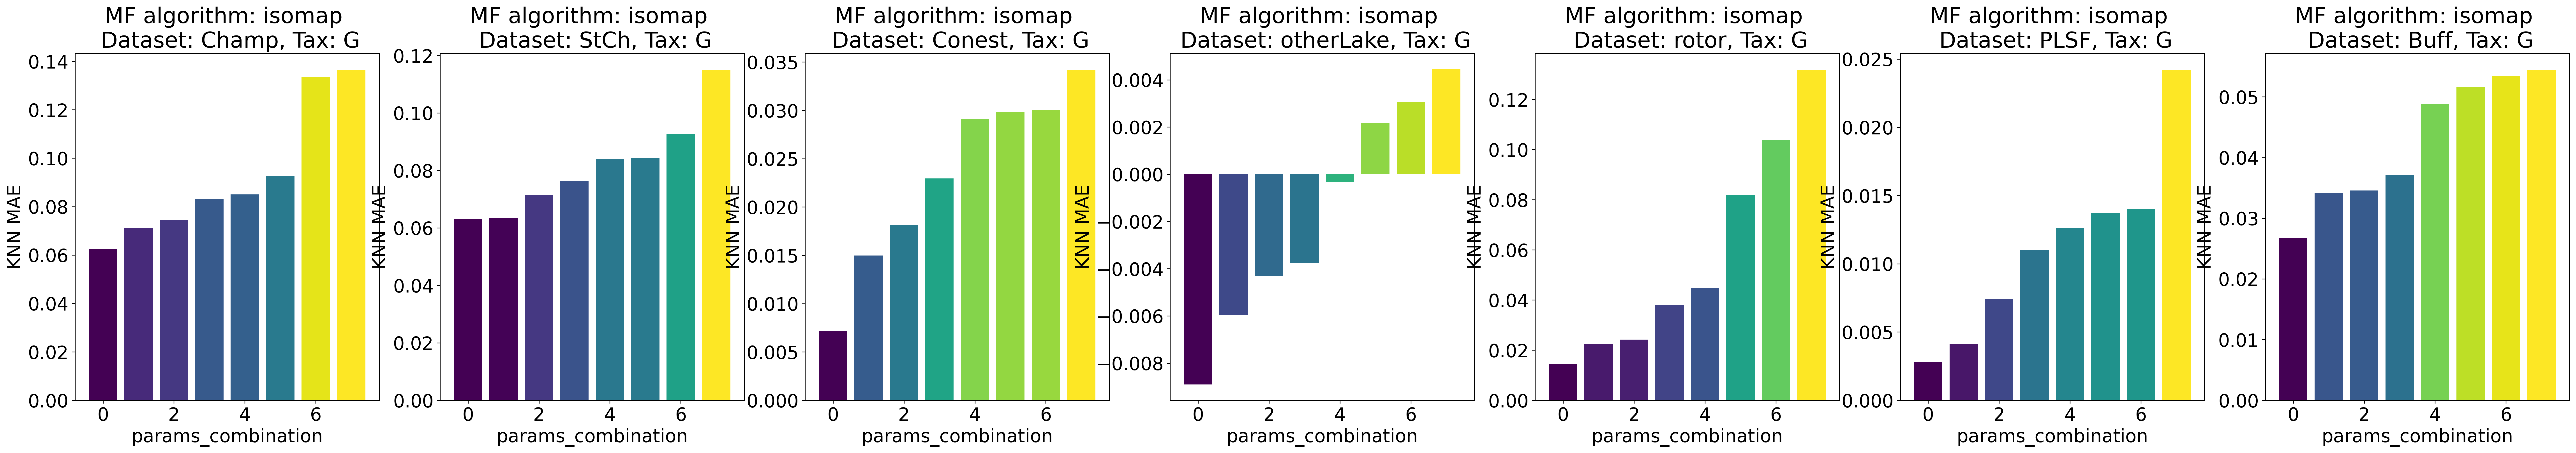

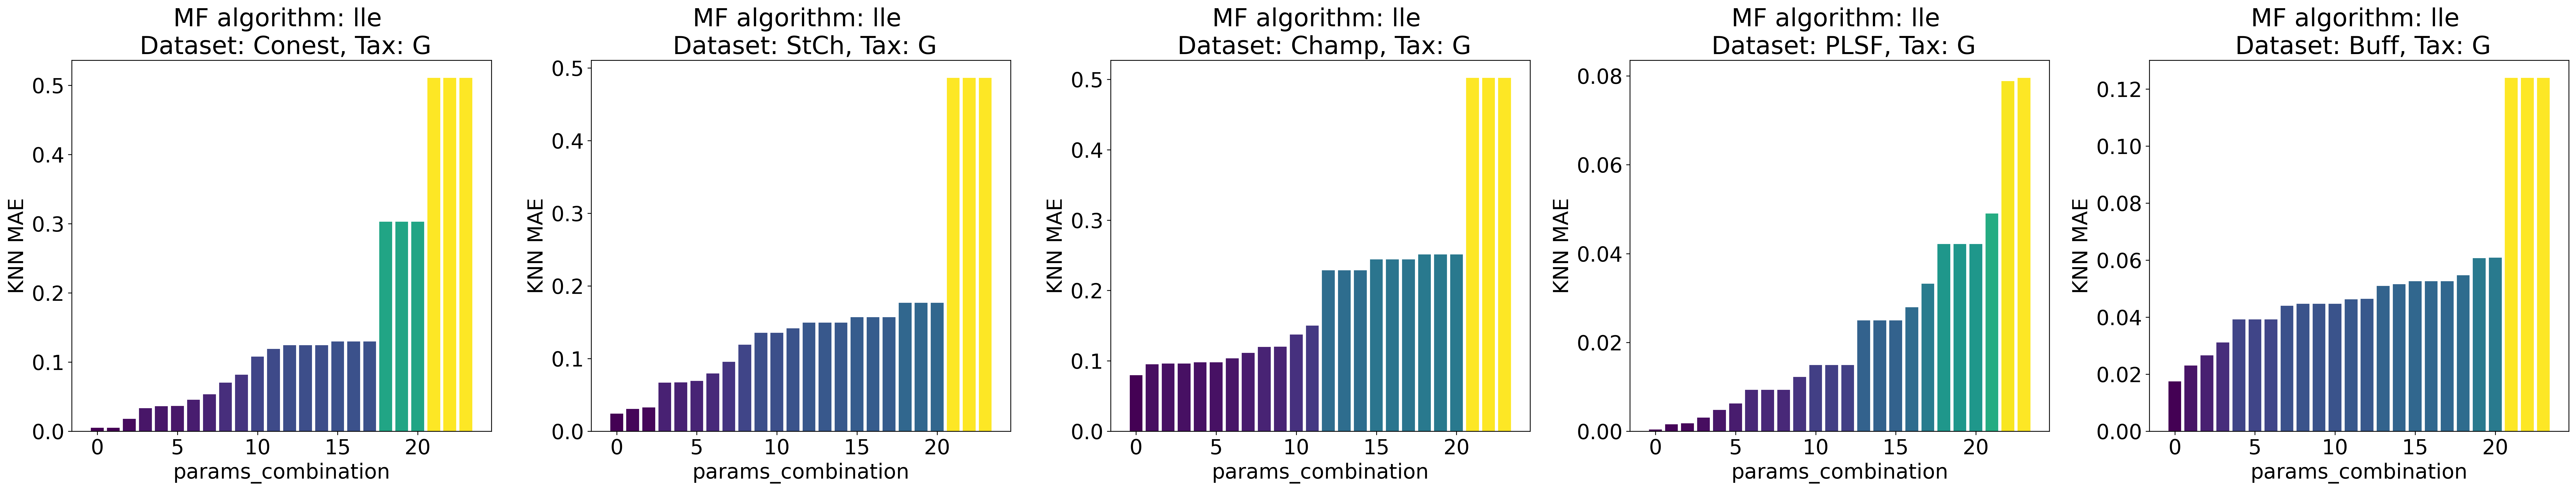

In [7]:
plt.rcParams.update({'font.size': 20})
best_params = defaultdict(dict)

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

for mf_type, mf_metrics in all_metrics.items():
    mf_metrics_items = mf_metrics.items()
    
    fig, axes = plt.subplots(nrows=1, 
                             ncols = len(mf_metrics_items), 
                             figsize=(len(mf_metrics_items)*7, 7), 
                             dpi=300)
    
    for i,(label, mf_label_metrics) in enumerate(mf_metrics_items):
        
        scores = np.array(mf_label_metrics['scores'])
        params = list(ParameterGrid(mf_label_metrics['params']))
        dataset_name = label.split('_')[0]
        tax_name = label.split('_')[-1]
        
        if include_Q_scores:
            maes = scores[:,-1]
        else:
            maes = scores
            
        mae_argmin = maes.argmin()
        
        best_params[label][mf_type] = params[mae_argmin] 
        
        # scatterplot with Q-metrics
        if include_Q_scores:
            sc = axes[i].scatter(scores[:,0], scores[:,1], c=scores[:,2])
            axes[i].set_xlabel('Q_loc')
            axes[i].set_ylabel('Q_glob')
        
        else:
            scores_rel = scores - baseline_errors[label]
            scores_rel = sorted(scores_rel)
            axes[i].bar(np.arange(len(scores_rel)), scores_rel, color=my_cmap(rescale(scores_rel)))
            axes[i].set_xlabel('params_combination')
            axes[i].set_ylabel('KNN MAE')
            
        axes[i].set_title(f'MF algorithm: {mf_type} \n Dataset: {dataset_name}, Tax: {tax_name.capitalize()}')
        
            
    if include_Q_scores:
        fig.colorbar(sc, orientation='vertical')
        
plt.tight_layout()        
plt.show()

# Train final embeddings

In [8]:
methods_dict = {
                'tsne':TSNE,
                'lle':LocallyLinearEmbedding,
                'umap':UMAP,
                'isomap':Isomap,
                'spectral':SpectralEmbedding
               }

Q_mae_scorer = lambda *args: (calculate_Q_metrics(*args) + [knn_mae_scorer(*args)])

PERCENTILE = 95
DATA_PERCENT_THRESHOLD = 0.9

for label, best_params_ in tqdm(best_params.items()):
    
    X_pca = data_pca[label]
    X_orig  = data_orig[label]
    intdim = intrinsic_dims[label]

    for method_name, params_dict in best_params_.items():
        
        embedding_path = os.path.join(embeddings_root, f'{label}_{method_name}')
        
        if os.path.isfile(embedding_path + '.npy'):
            print(embedding_path, f'Embedding for {method_name}, {label} exists! Skipping...') 
            
            d = np.load(embedding_path + '.npy', allow_pickle=True).item()
            
            mae = d['knn_mae']
            Q_loc = d['Q_loc']
            Q_glob = d['Q_glob']
            baseline_mae = d['knn_mae_base']
            
            mae_ = d['knn_mae_']
            Q_loc_ = d['Q_loc_']
            Q_glob_ = d['Q_glob_']
            baseline_mae_ = d['knn_mae_base_']
            
        else:
            print(embedding_path, f'Calculating for {method_name}, {label}...')  

            params_dict['n_jobs'] = -1

            # assert large `n_iter` for the final embedding
            if method_name == 'tsne':
                params_dict['n_iter'] = 2000
            elif method_name == 'umap':
                params_dict['n_epochs'] = 2000

            Z = methods_dict[method_name](n_components=intdim, **params_dict).fit_transform(X_pca)
            d = {'Z':Z}

            mae = knn_mae_scorer(X_orig, Z)
            baseline_mae = knn_mae_scorer(X_orig, X_orig)
            Q_loc, Q_glob = calculate_Q_metrics(X_orig, Z)

            d['Q_loc'] = Q_loc
            d['Q_glob'] = Q_glob
            d['knn_mae'] = mae
            d['knn_mae_base'] = baseline_mae 

            N = X_orig.shape[0]
            X_ = X_orig.copy()
            Z_ = Z.copy() 

            inliers_indexes = np.arange(N)
            # iteratively choosing subset of high-mae outliers
            maxiter = 20
            for _ in range(maxiter):
                scoring_list = KNN_MAE(X_, Z_, averaging=None, weights='distance', n_neighbors=5) 
                q = np.percentile(scoring_list, PERCENTILE)
                mask = scoring_list < q
                if mask.sum()/N < DATA_PERCENT_THRESHOLD:
                    break
                X_ = X_[mask]
                Z_ = Z_[mask]
                inliers_indexes = inliers_indexes[mask]

            outliers_indexes = set(np.arange(N)) - set(inliers_indexes)
            # cast set to np.array
            outliers_indexes = np.array(list(outliers_indexes))

            mae_ = knn_mae_scorer(X_, Z_)
            baseline_mae_ = knn_mae_scorer(X_, X_)
            Q_loc_, Q_glob_ = calculate_Q_metrics(X_, Z_)

            d['inliers_indexes_mae'] = inliers_indexes
            d['outliers_indexes_mae'] = outliers_indexes
            d['X_'] = X_
            d['Z_'] = Z_ # final embedding
            d['Q_loc_'] = Q_loc_ 
            d['Q_glob_'] = Q_glob_ 
            d['knn_mae_'] = mae_ # final mae
            d['knn_mae_base_'] = baseline_mae_ 

            np.save(embedding_path, d)   

        print(f'Initial metrics: mae={mae}, Q_loc={Q_loc}, Q_glob={Q_glob}, baseline_error: {baseline_mae}') 
        print(f'After removing outliers: mae={mae_}, Q_loc={Q_loc_}, Q_glob={Q_glob_}, baseline_error: {baseline_mae_}')
        print('-----------------------------------------------------------','\n')


  0%|                                                                                                                | 0/7 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


results/embeddingsdata_processed_small/rotor_g_umap Calculating for umap, rotor_g...
Initial metrics: mae=0.4085414741695716, Q_loc=0.5857142857142856, Q_glob=0.8305345852676368, baseline_error: 0.3312675991017219
After removing outliers: mae=0.3861647661584017, Q_loc=0.606060606060606, Q_glob=0.8326560598106194, baseline_error: 0.35157550015634687
----------------------------------------------------------- 

results/embeddingsdata_processed_small/rotor_g_tsne Calculating for tsne, rotor_g...


 14%|██████████████▊                                                                                         | 1/7 [00:05<00:32,  5.42s/it]

Initial metrics: mae=0.3992709892052718, Q_loc=0.8, Q_glob=0.7716267015828207, baseline_error: 0.3312675991017219
After removing outliers: mae=0.35030533844772216, Q_loc=0.8181818181818182, Q_glob=0.7769339175159085, baseline_error: 0.3191452404778729
----------------------------------------------------------- 

results/embeddingsdata_processed_small/rotor_g_spectral Calculating for spectral, rotor_g...
Initial metrics: mae=0.41273706751481404, Q_loc=0.6214285714285714, Q_glob=0.7921928670566131, baseline_error: 0.3312675991017219
After removing outliers: mae=0.38669111713641036, Q_loc=0.6515151515151516, Q_glob=0.7939983183483177, baseline_error: 0.3191452404778729
----------------------------------------------------------- 

results/embeddingsdata_processed_small/rotor_g_isomap Calculating for isomap, rotor_g...
Initial metrics: mae=0.36403507569239024, Q_loc=0.7142857142857144, Q_glob=0.937682170079814, baseline_error: 0.3312675991017219
After removing outliers: mae=0.36095202674290

 29%|█████████████████████████████▋                                                                          | 2/7 [00:09<00:23,  4.66s/it]

Initial metrics: mae=0.33684657979333665, Q_loc=0.33888888888888885, Q_glob=0.6336939323558308, baseline_error: 0.2107857239841236
After removing outliers: mae=0.334196889525805, Q_loc=0.3653846153846154, Q_glob=0.643982634710286, baseline_error: 0.21006321779958317
----------------------------------------------------------- 

results/embeddingsdata_processed_small/Conest_g_spectral Calculating for spectral, Conest_g...
Initial metrics: mae=0.24517180004628947, Q_loc=0.6036060606060606, Q_glob=0.8484179630675233, baseline_error: 0.2107857239841236
After removing outliers: mae=0.2442893379689749, Q_loc=0.598301282051282, Q_glob=0.8445722789013458, baseline_error: 0.20993414869469548
----------------------------------------------------------- 

results/embeddingsdata_processed_small/Conest_g_isomap Calculating for isomap, Conest_g...
Initial metrics: mae=0.24538324783371862, Q_loc=0.7120933828076685, Q_glob=0.9370549047493302, baseline_error: 0.2107857239841236
After removing outliers: m

 43%|████████████████████████████████████████████▌                                                           | 3/7 [00:13<00:17,  4.38s/it]

Initial metrics: mae=0.36513214981137987, Q_loc=0.41509433962264153, Q_glob=0.631046087237379, baseline_error: 0.25620280877436175
After removing outliers: mae=0.35902926789319245, Q_loc=0.44, Q_glob=0.6414825535720877, baseline_error: 0.2684147251782333
----------------------------------------------------------- 

results/embeddingsdata_processed_small/StCh_g_spectral Calculating for spectral, StCh_g...
Initial metrics: mae=0.36823914172853, Q_loc=0.49854419362084457, Q_glob=0.7211535680033099, baseline_error: 0.25620280877436175
After removing outliers: mae=0.361992853767166, Q_loc=0.5149345238095238, Q_glob=0.7342043892936243, baseline_error: 0.2502476541170849
----------------------------------------------------------- 

results/embeddingsdata_processed_small/StCh_g_isomap Calculating for isomap, StCh_g...
Initial metrics: mae=0.3372257562779072, Q_loc=0.6469055496994539, Q_glob=0.8930553959985426, baseline_error: 0.25620280877436175
After removing outliers: mae=0.3176202515116685,

 57%|███████████████████████████████████████████████████████████▍                                            | 4/7 [00:19<00:14,  4.82s/it]

Initial metrics: mae=0.20715867499930918, Q_loc=0.76875, Q_glob=0.8432511236591922, baseline_error: 0.18164114650265173
After removing outliers: mae=0.19739690476295252, Q_loc=0.7916666666666666, Q_glob=0.853526181438172, baseline_error: 0.17279881927577265
----------------------------------------------------------- 

results/embeddingsdata_processed_small/Buff_g_spectral Calculating for spectral, Buff_g...
Initial metrics: mae=0.2350525227863025, Q_loc=0.731387037276689, Q_glob=0.9290631027714371, baseline_error: 0.18164114650265173
After removing outliers: mae=0.21923484312409974, Q_loc=0.7313544900666115, Q_glob=0.9309826683627359, baseline_error: 0.18055322891034883
----------------------------------------------------------- 

results/embeddingsdata_processed_small/Buff_g_isomap Calculating for isomap, Buff_g...
Initial metrics: mae=0.22914292955531418, Q_loc=0.7513281299553621, Q_glob=0.9497948279271444, baseline_error: 0.18164114650265173
After removing outliers: mae=0.2089041497

 71%|██████████████████████████████████████████████████████████████████████████▎                             | 5/7 [00:23<00:09,  4.58s/it]

Initial metrics: mae=0.2547761044510175, Q_loc=0.6425611020923521, Q_glob=0.8117569545566666, baseline_error: 0.23972440509253956
After removing outliers: mae=0.24729733240966456, Q_loc=0.6820841650033267, Q_glob=0.8173785824545857, baseline_error: 0.22970295254925993
----------------------------------------------------------- 

results/embeddingsdata_processed_small/PLSF_g_spectral Calculating for spectral, PLSF_g...
Initial metrics: mae=0.28288320149072754, Q_loc=0.6362575461155004, Q_glob=0.9027192752959485, baseline_error: 0.23972440509253956
After removing outliers: mae=0.2636269175786198, Q_loc=0.6755113072431561, Q_glob=0.9085615961345449, baseline_error: 0.22970295254925993
----------------------------------------------------------- 

results/embeddingsdata_processed_small/PLSF_g_isomap Calculating for isomap, PLSF_g...
Initial metrics: mae=0.27666544872101706, Q_loc=0.6718045624732688, Q_glob=0.9280457253322943, baseline_error: 0.23972440509253956
After removing outliers: mae=

 86%|█████████████████████████████████████████████████████████████████████████████████████████▏              | 6/7 [00:24<00:03,  3.44s/it]

Initial metrics: mae=0.6188336258687656, Q_loc=0.5191256830601092, Q_glob=0.7330463504655879, baseline_error: 0.36076278777237614
After removing outliers: mae=0.5604311605336095, Q_loc=0.549590643274854, Q_glob=0.7395975720685919, baseline_error: 0.3458052375815669
----------------------------------------------------------- 

results/embeddingsdata_processed_small/otherLake_g_spectral Calculating for spectral, otherLake_g...
Initial metrics: mae=0.6194793380256469, Q_loc=0.459927140255009, Q_glob=0.7691310397278321, baseline_error: 0.36076278777237614
After removing outliers: mae=0.569219134008928, Q_loc=0.5019493177387914, Q_glob=0.773817186409168, baseline_error: 0.3514774634297911
----------------------------------------------------------- 

results/embeddingsdata_processed_small/otherLake_g_isomap Calculating for isomap, otherLake_g...
Initial metrics: mae=0.48794524226423275, Q_loc=0.628553364171844, Q_glob=0.9074123160991854, baseline_error: 0.36076278777237614
After removing out

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:33<00:00,  4.83s/it]

Initial metrics: mae=0.22779063927656384, Q_loc=0.6288659793814433, Q_glob=0.8702310855366022, baseline_error: 0.1387989412377181
After removing outliers: mae=0.2194974947219293, Q_loc=0.6521739130434783, Q_glob=0.8739976591818192, baseline_error: 0.13185423375407376
----------------------------------------------------------- 

results/embeddingsdata_processed_small/Champ_g_lle Calculating for lle, Champ_g...
Initial metrics: mae=0.26143813858032766, Q_loc=0.5773159325811027, Q_glob=0.8542230835063498, baseline_error: 0.1387989412377181
After removing outliers: mae=0.2535456679374184, Q_loc=0.5886236347876038, Q_glob=0.8578164583282849, baseline_error: 0.13485503841354013
----------------------------------------------------------- 



# Visualize Q metrics

In [9]:
data_embeddings = defaultdict(dict)

for embedding_name in os.listdir(embeddings_root):
    if embedding_name == ".DS_Store":
        continue

    try:
        print(f"Processing file: {embedding_name}")
        dataset_name, tax_name, embedding_type = embedding_name.split('.')[0].split('_')
        embedding_path = os.path.join(embeddings_root, embedding_name)
        d = np.load(embedding_path, allow_pickle=True).item()
        label = dataset_name + '_' + tax_name
        data_embeddings[label][embedding_type] = d  
        
    except ValueError:
        print(f"Problem with file: {embedding_name}")
        
print(f"Keys in data_embeddings now: {data_embeddings.keys()}") 





Processing file: Buff_g_isomap.npy
Processing file: Conest_g_isomap.npy
Processing file: Champ_g_tsne.npy
Processing file: Champ_g_umap.npy
Processing file: Champ_g_isomap.npy
Processing file: StCh_g_tsne.npy
Processing file: rotor_g_spectral.npy
Processing file: StCh_g_umap.npy
Processing file: StCh_g_lle.npy
Processing file: PLSF_g_lle.npy
Processing file: rotor_g_umap.npy
Processing file: rotor_g_tsne.npy
Processing file: Conest_g_spectral.npy
Processing file: otherLake_g_spectral.npy
Processing file: Conest_g_lle.npy
Processing file: PLSF_g_spectral.npy
Processing file: otherLake_g_umap.npy
Processing file: Conest_g_tsne.npy
Processing file: PLSF_g_umap.npy
Processing file: Conest_g_umap.npy
Processing file: PLSF_g_tsne.npy
Processing file: rotor_g_isomap.npy
Processing file: PLSF_g_isomap.npy
Processing file: StCh_g_spectral.npy
Processing file: Champ_g_lle.npy
Processing file: Buff_g_tsne.npy
Processing file: Buff_g_spectral.npy
Processing file: Buff_g_umap.npy
Processing file: B

In [10]:
xytext_positions_pat07 = {
                          'AGP_o_isomap':(-60, -5),
                          'AGP_o_spectral':(-20, 10),
                          'AGP_o_lle':(-25, 7),#
                          'AGP_f_umap':(-10, 10),
                          'AGP_f_lle':(5,-10),
                          'AGP_f_ae':(5,-15), #
                          'AGP_f_spectral':(-30, -5),
                          'AGP_f_isomap':(-30, -15),#
                          'AGP_g_lle':(-30,0),#
                          'AGP_g_ae':(-25,0),
                          'AGP_g_umap':(-20,5), # 
                          'AGP_g_isomap':(-60, 0), #
                          'AGP_g_spectral':(-20, 10),#
                          'HMP_o_spectral': (10,-20),
                          'HMP_o_lle': (10,-10), #
                          'HMP_o_umap': (10,-20),
                          'HMP_o_isomap': (-30, -20),
                          'HMP_f_lle': (-15, -20), 
                          'HMP_f_isomap': (-15, 10), #
                          'HMP_f_spectral': (0, -20), #
                          'HMP_g_spectral': (-5, -15), 
                          'HMP_g_lle': (5, -10), #
                          'HMP_g_tsne': (-48, -5), 
                          'HMP_g_ae': (-25, 5),
                          'HMP_g_umap': (5, -5),
                          'HMP_g_isomap': (5, -3) #
                         }

In [ ]:
xytext_positions_nopat = {'AGP_o_tsne':(-22, 10),
                          'AGP_o_isomap':(-40, -25),
                          'AGP_f_umap':(-15, 10),
                          'AGP_f_lle':(10,0),
                          'AGP_f_ae':(-10,-20),
                          'AGP_f_spectral':(-10, -20),
                          'AGP_g_isomap':(-60, 0),
                          'HMP_o_lle': (-30,-15), 
                          'HMP_o_umap': (0,-20),
                          'HMP_f_lle': (-10, 10), 
                          'HMP_g_spectral': (-5, -20), 
                          'HMP_g_lle': (5, -10), 
                          'HMP_g_isomap': (5, -10) 
                         }

No handles with labels found to put in legend.


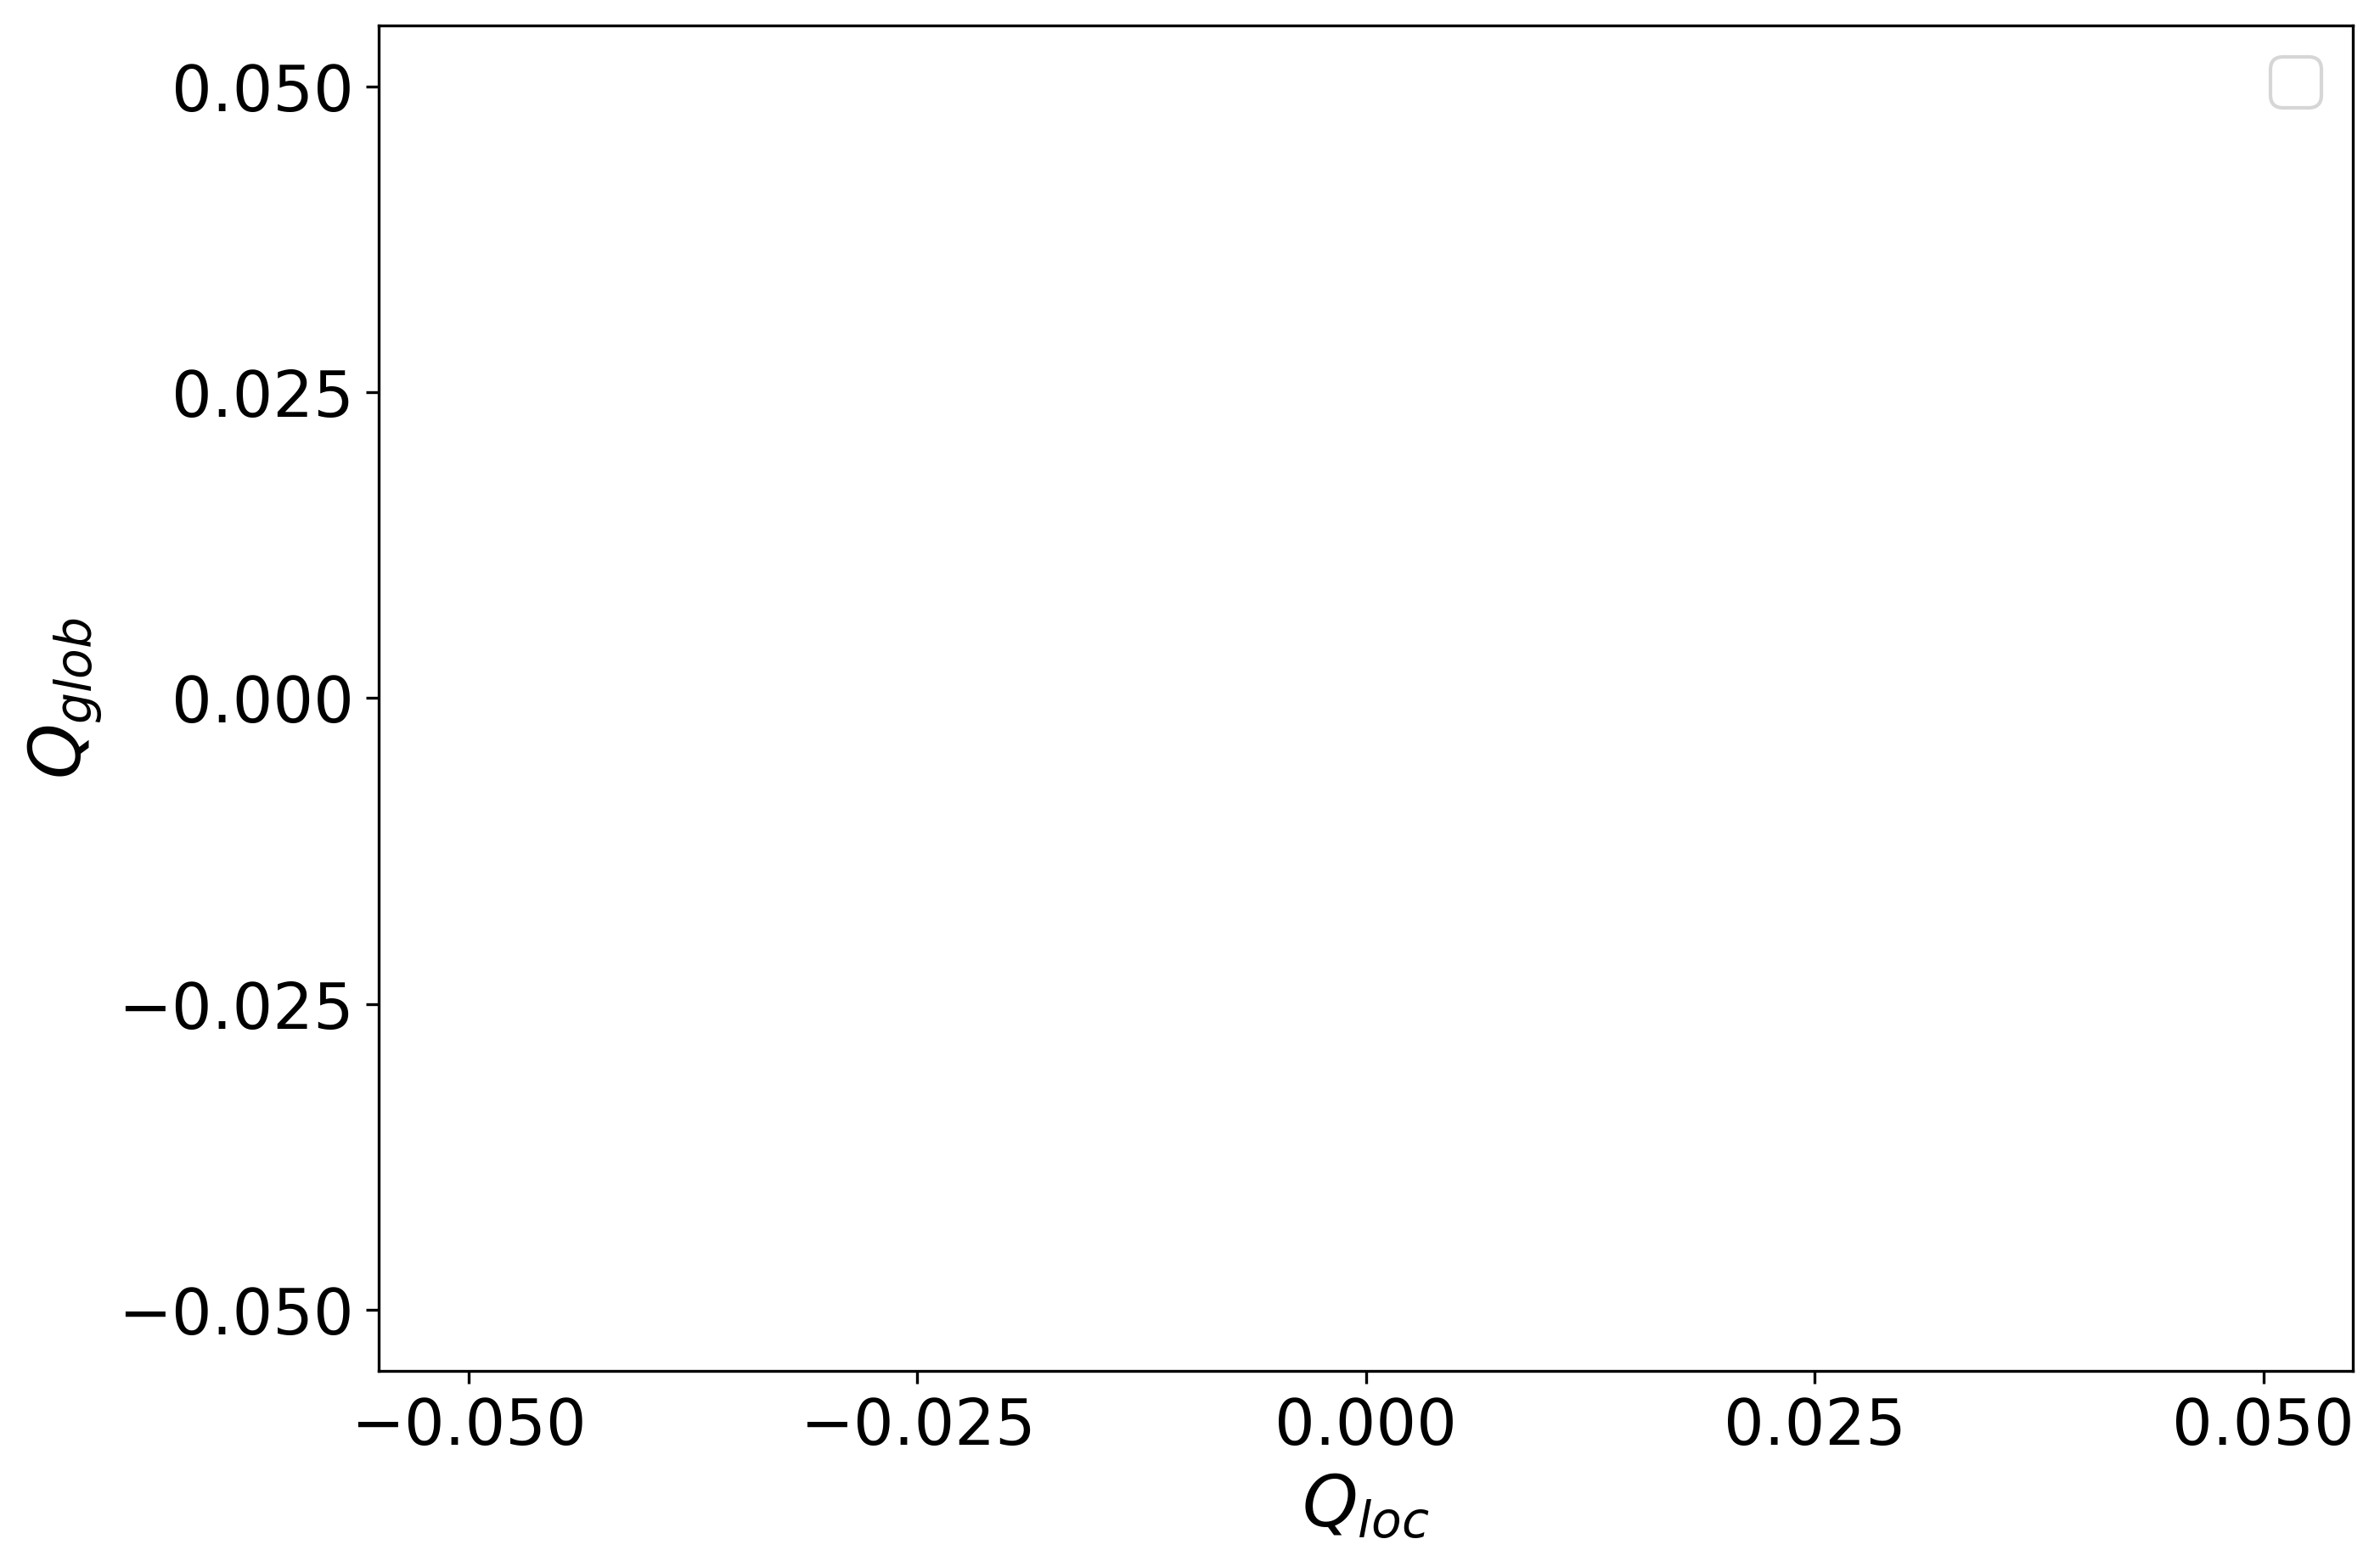

In [11]:
MSIZE=70

#xytext_positions_dict = {'':xytext_positions_nopat,
#                         '_pat0.7':xytext_positions_pat07}

fig=plt.figure(figsize=(10,7),dpi=300)
fig.set_facecolor('white')
plt.xlabel(r"$Q_{loc}$", fontsize=20)
plt.ylabel(r"$Q_{glob}$", fontsize=20)

embeddingname_dict = {'spectral':'SE',
                       'ae':'AE',
                       'tsne':'t-SNE',
                       'umap':'UMAP',
                       'isomap':'Isomap',
                       'lle':'LLE',
                       'pca': 'PCA'}

markerdict = {
#    'o':'o',
#    'f':'s',
     'g':'*',
}

for dataset_name in ['Sanger', 'Illumina']:
    for tax_name in ['g']:
        label = dataset_name + '_' + tax_name
        
        data_embeddings_label = data_embeddings[label]
        
        for i, (embedding_name, metrics_dict) in enumerate(data_embeddings_label.items()):

            x = metrics_dict['Q_loc']
            y = metrics_dict['Q_glob']

            marker = markerdict[tax_name]
            color = 'maroon' if dataset_name == 'Sanger' else 'steelblue'

            legend_label = f'{dataset_name}, Tax {tax_name.capitalize()}' if i == 0 else None
            
            mp = plt.scatter(x, 
                             y, 
                             c=color, 
                             s=MSIZE, 
                             marker=marker, 
                             alpha=0.5,
                             label=legend_label)
    
            txt = embeddingname_dict[embedding_name]
            
            # adjusting text position
            try:
                xytext = xytext_positions_dict[DATA_SPECIFICATION][label + '_' + embedding_name]
            except:
                xytext = (5,5)

            plt.annotate(txt, 
                         (x, y), 
                         annotation_clip=True, 
                         fontsize=15, 
                         xytext=xytext, 
                         textcoords="offset points")
    
plt.legend(fontsize=18)
plt.locator_params(nbins=5)
plt.tick_params(axis='both', labelsize=18)
plt.show()

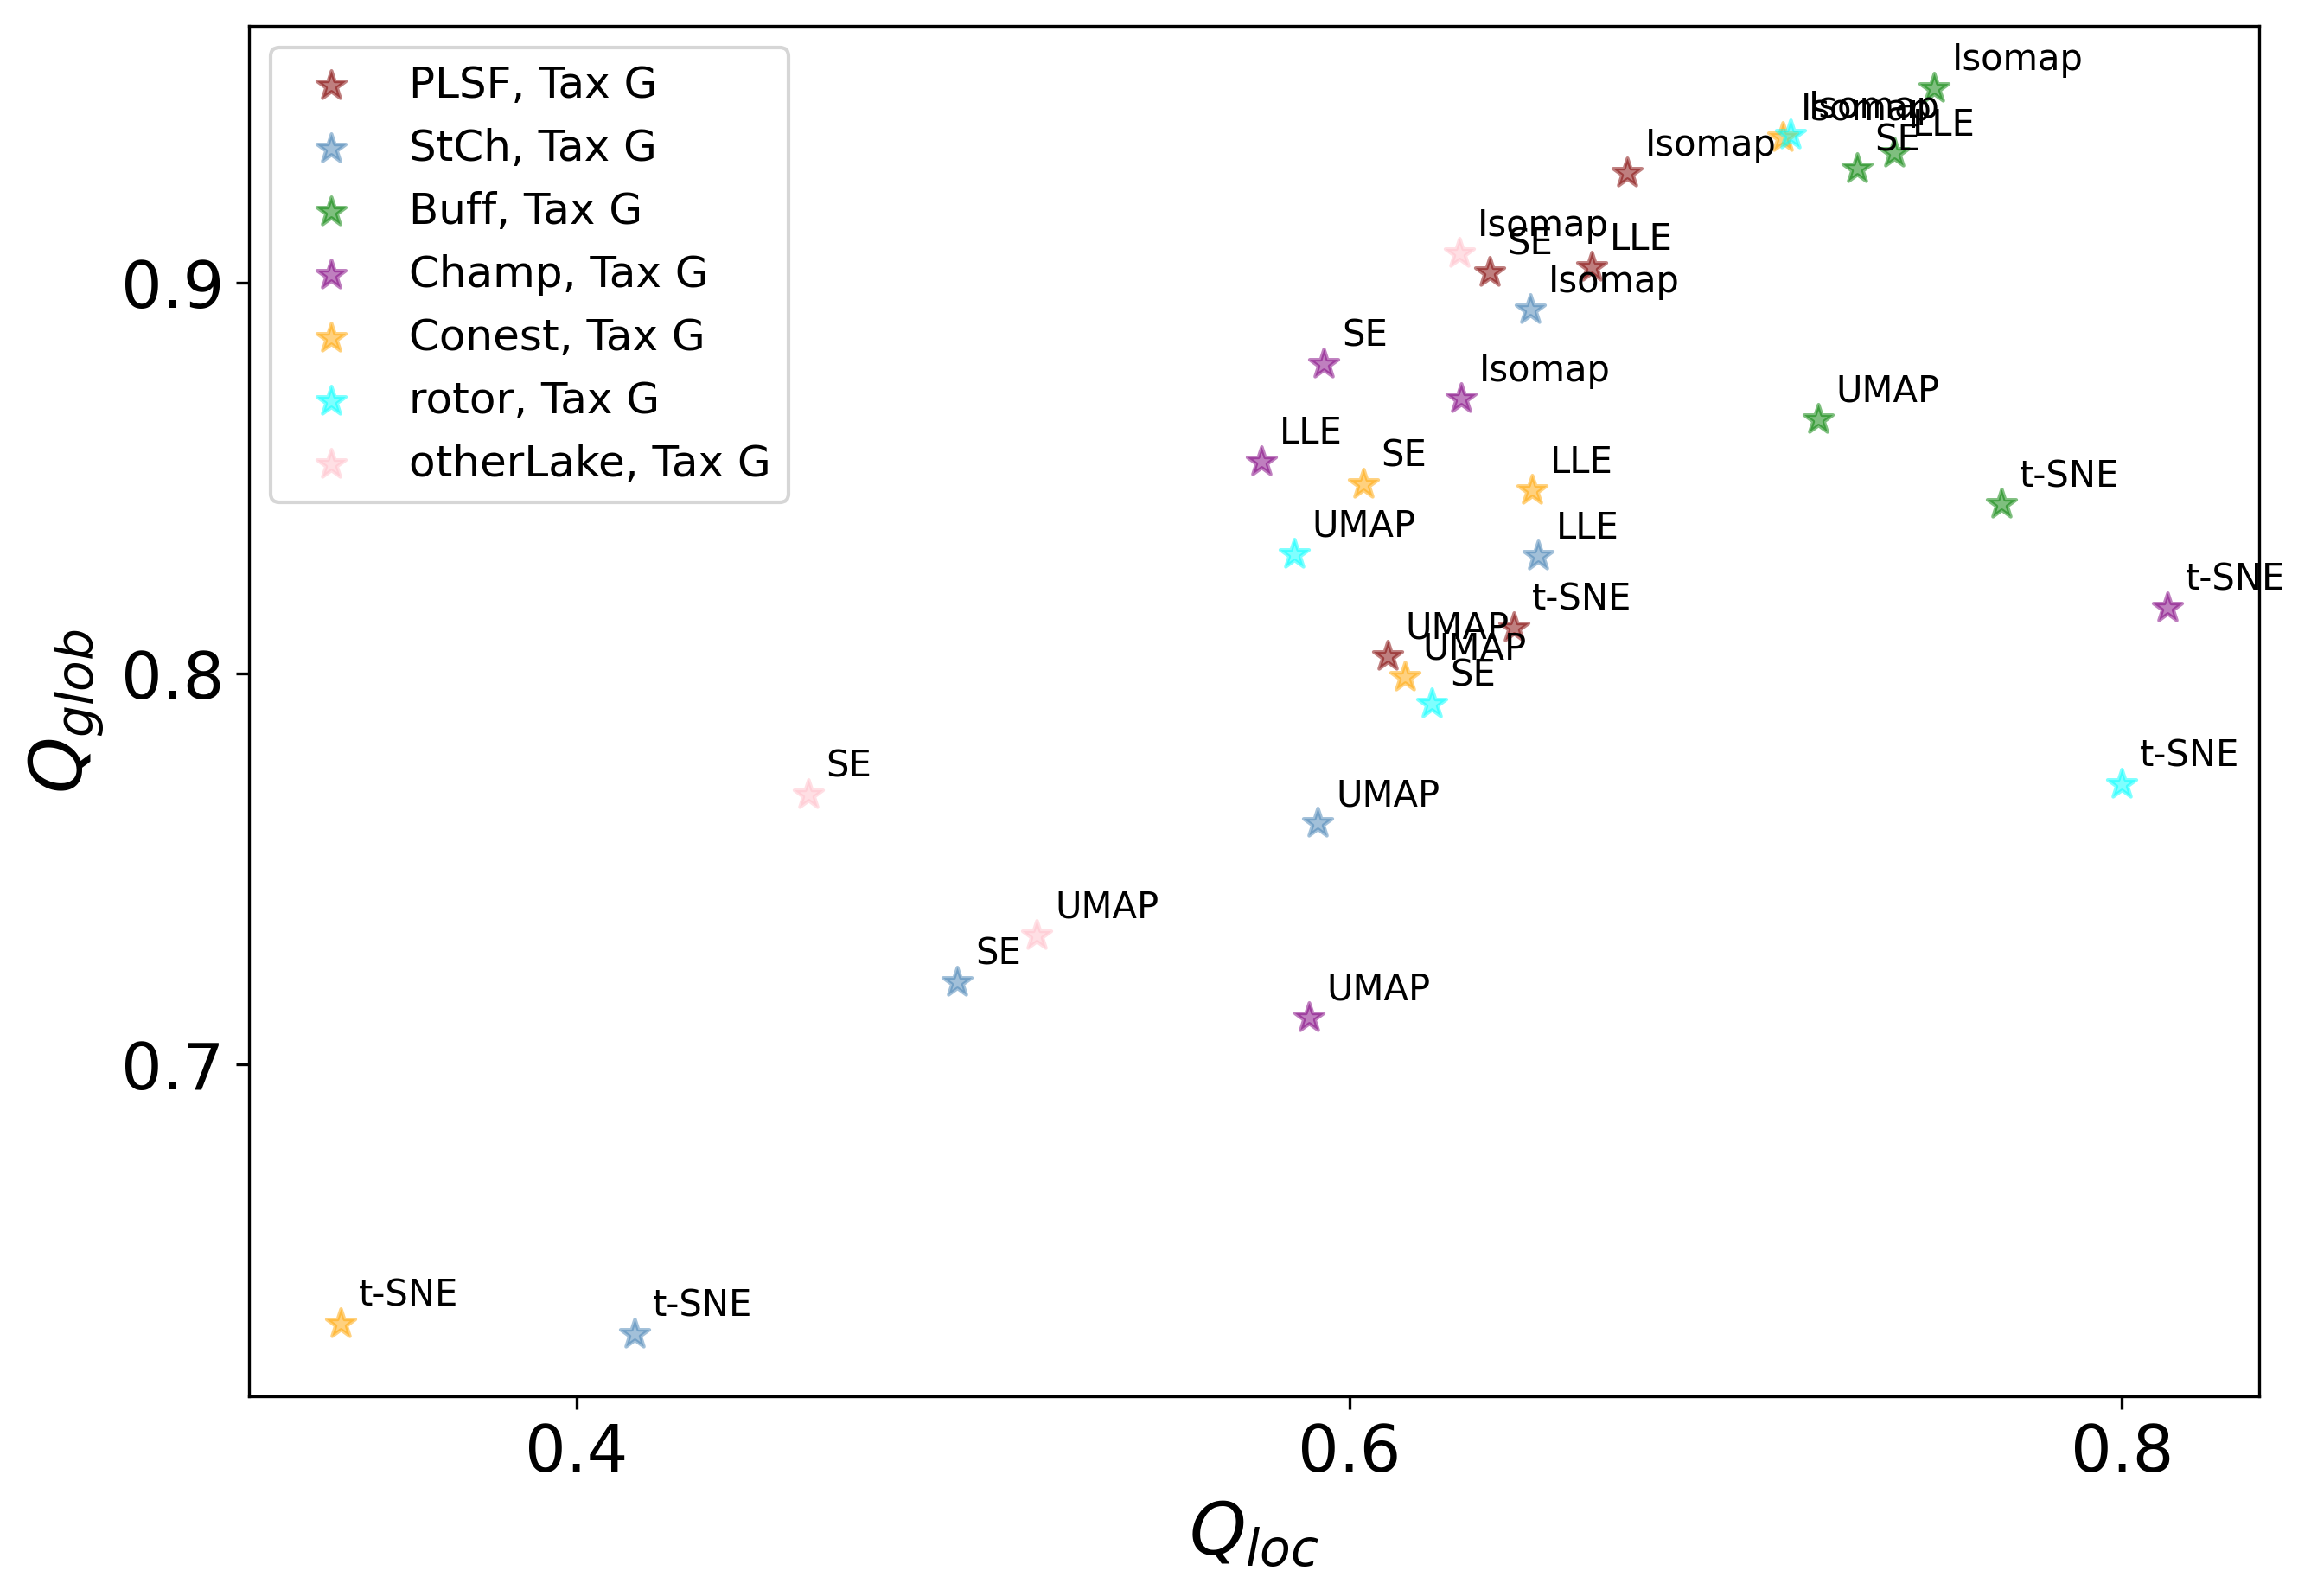

In [12]:
MSIZE = 70

# Expected datasets
datasets = ['PLSF', 'StCh', 'Buff', 'Champ', 'Conest', 'rotor', 'otherLake']

fig = plt.figure(figsize=(10, 7), dpi=300)
fig.set_facecolor('white')
plt.xlabel(r"$Q_{loc}$", fontsize=20)
plt.ylabel(r"$Q_{glob}$", fontsize=20)

embeddingname_dict = {
    'spectral': 'SE',
    'ae': 'AE',
    'tsne': 't-SNE',
    'umap': 'UMAP',
    'isomap': 'Isomap',
    'lle': 'LLE',
    'pca': 'PCA'
}

markerdict = {
    'g': '*',
}


color_list = ['maroon', 'steelblue', 'green', 'purple', 'orange', 'cyan', 'pink']  # Add more if needed


#...[rest of your code above this]

# Reduce fontsize of annotations
fontsize_annotations = 10

for idx, dataset_name in enumerate(datasets):
    label = dataset_name + '_g'

    data_embeddings_label = data_embeddings[label]

    for i, (embedding_name, metrics_dict) in enumerate(data_embeddings_label.items()):
        x = metrics_dict['Q_loc']
        y = metrics_dict['Q_glob']

        marker = markerdict['g']
        color = color_list[idx % len(color_list)]  # cycle through colors
        
        legend_label = f'{dataset_name}, Tax {tax_name.capitalize()}' if i == 0 else None
            
        mp = plt.scatter(x, 
                             y, 
                             c=color, 
                             s=MSIZE, 
                             marker=marker, 
                             alpha=0.5,
                             label=legend_label)
    
        txt = embeddingname_dict[embedding_name]

        #plt.scatter(x, y, c=color, s=MSIZE, marker=marker, alpha=0.5, label=legend_label)

        #txt = embeddingname_dict[embedding_name]
        plt.annotate(txt, (x, y), annotation_clip=True, fontsize=fontsize_annotations, xytext=(5, 5), textcoords="offset points")

plt.legend(fontsize=12)  # reduced font size for legend
plt.locator_params(nbins=5)
plt.tick_params(axis='both', labelsize=18)
plt.show()

